## Forecast the minutes watched by a viewer in the next two weeks given their viewing behaviour over the last 16 weeks

We have data for about 10,000 viewers of iPlayer that tells us when they watched what programme. We will use this data to try and see whether we can predict how 'loyal' a viewer is. We have no data about the viewers themselves

In [1]:
# Import all relevent libraries to analyse the data
import pandas as pd
import numpy as np
import datetime
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Set options to display all columns
pd.set_option("display.max_columns",None)

### Import the data and preprocess for analysis

In [3]:
# Load the data into a pandas dataframe and display first couple of rows to see what it looks like
data=pd.read_csv('iplayer_data_sample_janapr2017.csv', parse_dates=['start_date_time'])
data.head()

,user_id,program_id,series_id,genre,programme_duration,streaming_id,start_date_time,time_viewed
0,cd2006,f6d3d8,a282ca,Factual,00:00:21,1486911129420_1,2017-02-12 14:51:24.544,20920.0
1,cd2006,b8fbf2,e0480e,Comedy,00:01:51,1484864257965_1,2017-01-19 22:17:04.648,111285.0
2,cd2006,e2f113,933a1b,Factual,00:00:30,1487099603980_1,2017-02-14 19:12:36.667,29945.0
3,cd2006,0e0916,b68e79,Entertainment,00:01:22,1484773546557_1,2017-01-18 21:05:11.466,82620.0
4,cd2006,ca03b9,5d0813,Sport,00:01:37,1486911176609_1,2017-02-12 14:52:08.965,97444.0


In [4]:
# Enhance the data with a few additional columns that make it easier to analyse the data 

# Get the weekday
def get_weekday(formated_time):
    return 'weekday_' + str(formated_time.weekday())

# Get the two-week number. We will forecast the minutes watched in the last two weeks
# Python3 rounds 0.5 up and down depending on the integer so we can't use round function
def get_twoweeknumber(formated_time):
    return math.floor(formated_time.isocalendar()[1]/2.0)


# Get the time of day
def get_timeofday(formated_time):
    hour=formated_time.hour
    if hour in range(5,13):
        return 'Morning'
    elif hour in range(13,18):
        return 'Afternoon'
    elif hour in range(18,23):
        return 'Evening'
    else:
        return 'Night'

# Parse the programme duration and turn it into minutes so that we can compute the percentage of time watched
def parse_programme_duration(unformated_time):
    try:
        timeparts=unformated_time.split(':')
        return int(timeparts[0])*60.0+int(timeparts[1])+int(timeparts[2])/60.0
    except:
        return

In [5]:
# Apply the functions to the dataframe
data['weekday']=data['start_date_time'].apply(get_weekday)
data['time_of_day']=data['start_date_time'].apply(get_timeofday)
data['programme_duration_mins']=data['programme_duration'].apply(parse_programme_duration)
data['twoweek']=data['start_date_time'].apply(get_twoweeknumber)

# I noticed some negative time viewed in the data, so assume that is error and make positive
data['time_viewed']=abs(data['time_viewed'])

# Convert time viewed and length of programme into minutes
data['min_watched']=data['time_viewed']/(60000.0)

data.head()

,user_id,program_id,series_id,genre,programme_duration,streaming_id,start_date_time,time_viewed,weekday,time_of_day,programme_duration_mins,twoweek,min_watched
0,cd2006,f6d3d8,a282ca,Factual,00:00:21,1486911129420_1,2017-02-12 14:51:24.544,20920.0,weekday_6,Afternoon,0.350000,3,0.348667
1,cd2006,b8fbf2,e0480e,Comedy,00:01:51,1484864257965_1,2017-01-19 22:17:04.648,111285.0,weekday_3,Evening,1.850000,1,1.854750
2,cd2006,e2f113,933a1b,Factual,00:00:30,1487099603980_1,2017-02-14 19:12:36.667,29945.0,weekday_1,Evening,0.500000,3,0.499083
3,cd2006,0e0916,b68e79,Entertainment,00:01:22,1484773546557_1,2017-01-18 21:05:11.466,82620.0,weekday_2,Evening,1.366667,1,1.377000
4,cd2006,ca03b9,5d0813,Sport,00:01:37,1486911176609_1,2017-02-12 14:52:08.965,97444.0,weekday_6,Afternoon,1.616667,3,1.624067


### Review the data to make sure we don't have anything too weird happening

In [6]:
# Check whether there is anything weird happening with our numerical values
data.describe()

,time_viewed,programme_duration_mins,twoweek,min_watched
count,4.889520e+05,457154.000000,490852.000000,488952.000000
mean,8.566017e+05,37.965896,4.291923,14.276694
std,3.491019e+06,43.716212,3.490338,58.183645
min,0.000000e+00,0.000000,0.000000,0.000000
25%,3.935000e+03,0.500000,2.000000,0.065583
50%,8.194200e+04,30.000000,4.000000,1.365700
75%,9.219720e+05,59.000000,6.000000,15.366200
max,8.515021e+08,720.000000,26.000000,14191.701283


In [7]:
# Check how many missing and unique values there are per column
features=data.columns.values
for feature in features:
    print(feature,'- Missing:', sum(data[feature].isnull()),'- Unique:', len(data[feature].unique()))

user_id - Missing: 0 - Unique: 9937
program_id - Missing: 33698 - Unique: 23857
series_id - Missing: 33698 - Unique: 5921
genre - Missing: 67719 - Unique: 12
programme_duration - Missing: 33698 - Unique: 891
streaming_id - Missing: 0 - Unique: 434430
start_date_time - Missing: 0 - Unique: 490626
time_viewed - Missing: 1900 - Unique: 259529
weekday - Missing: 0 - Unique: 7
time_of_day - Missing: 0 - Unique: 4
programme_duration_mins - Missing: 33698 - Unique: 891
twoweek - Missing: 0 - Unique: 10
min_watched - Missing: 1900 - Unique: 259529


So we will want to impute the genre to reduce the amount of missing data. After that the most useful column to impute is programme_duration. <br>
We could think about imputing series_id as well if we wanted to get really clever at a later stage. For the other missing variables imputation probably makes little sense.

In [8]:
# let's see whether we can guess the genre based on the series_id
series_mapping=pd.pivot_table(data,values='streaming_id', index=['series_id'],columns=['genre'], aggfunc=len).idxmax(axis=1)
series_mapping=pd.DataFrame(series_mapping).reset_index().rename(columns={0:'enriched_genre'})
series_mapping.head()

,series_id,enriched_genre
0,001b96,Factual
1,00389f,Factual
2,00400b,Children's
3,00434d,Factual
4,0079b7,Factual


In [9]:
# let's merge in the genre back into the data
data=pd.merge(data,series_mapping,how='left',on='series_id')
data[data['genre'].isnull()].head()

,user_id,program_id,series_id,genre,programme_duration,streaming_id,start_date_time,time_viewed,weekday,time_of_day,programme_duration_mins,twoweek,min_watched,enriched_genre
134,3387a6,47f8c1,c9cc1a,NaN,00:00:00,1485900618555_1,2017-01-31 22:10:20.049,3584.0,weekday_1,Evening,0.0,2,0.059733,Factual
140,3387a6,NaN,NaN,NaN,NaN,1489439401348_1,2017-03-13 21:10:02.421,3730.0,weekday_0,Evening,NaN,5,0.062167,NaN
141,3387a6,NaN,NaN,NaN,NaN,1485100892026_1,2017-01-22 16:01:34.292,3634.0,weekday_6,Afternoon,NaN,1,0.060567,NaN
142,3387a6,NaN,NaN,NaN,NaN,1489441109070_3,2017-03-13 21:38:30.203,3651.0,weekday_0,Evening,NaN,5,0.060850,NaN
143,3387a6,NaN,NaN,NaN,NaN,1493538827057_2,2017-04-30 07:53:47.559,3665.0,weekday_6,Morning,NaN,8,0.061083,NaN


In [10]:
# Check how many missing and unique values there are per column
features=data.columns.values
for feature in features:
    print(feature,'- Missing:', sum(data[feature].isnull()),'- Unique:', len(data[feature].unique()))

user_id - Missing: 0 - Unique: 9937
program_id - Missing: 33698 - Unique: 23857
series_id - Missing: 33698 - Unique: 5921
genre - Missing: 67719 - Unique: 12
programme_duration - Missing: 33698 - Unique: 891
streaming_id - Missing: 0 - Unique: 434430
start_date_time - Missing: 0 - Unique: 490626
time_viewed - Missing: 1900 - Unique: 259529
weekday - Missing: 0 - Unique: 7
time_of_day - Missing: 0 - Unique: 4
programme_duration_mins - Missing: 33698 - Unique: 891
twoweek - Missing: 0 - Unique: 10
min_watched - Missing: 1900 - Unique: 259529
enriched_genre - Missing: 43829 - Unique: 12


In [11]:
# What genre is the most popular at which time of day
genre_by_time=pd.pivot_table(data,values='streaming_id', index=['time_of_day'],columns=['enriched_genre'], aggfunc=len).idxmax(axis=1)
genre_by_time=pd.DataFrame(genre_by_time).reset_index().rename(columns={0:'enriched_genre'})
genre_by_time

,time_of_day,enriched_genre
0,Afternoon,Factual
1,Evening,Factual
2,Morning,Factual
3,Night,Factual


In [12]:
# Function that imputes a genre based on time of day if data is missing
def impute_genre(row):
    if isinstance(row['genre'],str):
        return row['genre']
    elif isinstance(row['enriched_genre'],str):
        return row['enriched_genre']
    else:
        return 'Factual'

In [13]:
# Apply the function to the dataframe
data['enriched_genre']=data.apply(impute_genre, axis=1)

In [14]:
# Check whether this has worked
data[data['genre'].isnull()].head()

,user_id,program_id,series_id,genre,programme_duration,streaming_id,start_date_time,time_viewed,weekday,time_of_day,programme_duration_mins,twoweek,min_watched,enriched_genre
134,3387a6,47f8c1,c9cc1a,NaN,00:00:00,1485900618555_1,2017-01-31 22:10:20.049,3584.0,weekday_1,Evening,0.0,2,0.059733,Factual
140,3387a6,NaN,NaN,NaN,NaN,1489439401348_1,2017-03-13 21:10:02.421,3730.0,weekday_0,Evening,NaN,5,0.062167,Factual
141,3387a6,NaN,NaN,NaN,NaN,1485100892026_1,2017-01-22 16:01:34.292,3634.0,weekday_6,Afternoon,NaN,1,0.060567,Factual
142,3387a6,NaN,NaN,NaN,NaN,1489441109070_3,2017-03-13 21:38:30.203,3651.0,weekday_0,Evening,NaN,5,0.060850,Factual
143,3387a6,NaN,NaN,NaN,NaN,1493538827057_2,2017-04-30 07:53:47.559,3665.0,weekday_6,Morning,NaN,8,0.061083,Factual


In [15]:
# Check the average length of a programme based on genre 
length_by_genre=data.groupby('genre')['programme_duration_mins'].median()
length_by_genre=pd.DataFrame(length_by_genre).reset_index().rename(columns={'programme_duration_mins':'enriched_duration_mins'})
length_by_genre

,genre,enriched_duration_mins
0,Children's,15.0
1,Comedy,28.0
2,Drama,45.0
3,Entertainment,30.0
4,Factual,45.0
5,Learning,10.0
6,Music,60.0
7,News,30.0
8,Religion & Ethics,60.0
9,Sport,80.0


In [16]:
# Function that imputes a length of programme based on genre if data is missing
def impute_duration(row):
    if row['programme_duration_mins']>0:
        return row['programme_duration_mins']
    else:
        if row['enriched_genre']=="Children's":
            return 15.0
        elif row['enriched_genre']=="Comedy":
            return 28.0
        elif row['enriched_genre']=="Drama":
            return 45.0
        elif row['enriched_genre']=="Entertainment":
            return 30.0
        elif row['enriched_genre']=="Factual":
            return 45.0
        elif row['enriched_genre']=="Learning":
            return 10.0
        elif row['enriched_genre']=="Music":
            return 60.0
        elif row['enriched_genre']=="News":
            return 30.0
        elif row['enriched_genre']=="Religion & Ethics":
            return 60.0
        elif row['enriched_genre']=="Sport":
            return 80.0
        elif row['enriched_genre']=="Weather":
            return 30.0

In [17]:
# Apply the function to the dataframe
data['enhanced_duration_mins']=data.apply(impute_duration, axis=1)

In [18]:
# Check whether this has worked
data[data['programme_duration_mins'].isnull()].head()

,user_id,program_id,series_id,genre,programme_duration,streaming_id,start_date_time,time_viewed,weekday,time_of_day,programme_duration_mins,twoweek,min_watched,enriched_genre,enhanced_duration_mins
140,3387a6,NaN,NaN,NaN,NaN,1489439401348_1,2017-03-13 21:10:02.421,3730.0,weekday_0,Evening,NaN,5,0.062167,Factual,45.0
141,3387a6,NaN,NaN,NaN,NaN,1485100892026_1,2017-01-22 16:01:34.292,3634.0,weekday_6,Afternoon,NaN,1,0.060567,Factual,45.0
142,3387a6,NaN,NaN,NaN,NaN,1489441109070_3,2017-03-13 21:38:30.203,3651.0,weekday_0,Evening,NaN,5,0.060850,Factual,45.0
143,3387a6,NaN,NaN,NaN,NaN,1493538827057_2,2017-04-30 07:53:47.559,3665.0,weekday_6,Morning,NaN,8,0.061083,Factual,45.0
144,3387a6,NaN,NaN,NaN,NaN,1489258896796_3,2017-03-11 19:01:39.890,3545.0,weekday_5,Evening,NaN,5,0.059083,Factual,45.0


In [19]:
# Clean up the percentage watched field from when the number is more than 100%
def clean_perc_watched(number):
    return min(number,1)

In [20]:
# Calculate how much of the programme the viewer watched
data['percentage_watched']=(data['min_watched']/data['enhanced_duration_mins'])

# Clean up percentaged watched from anything bigger than 100%
data['percentage_watched']=data['percentage_watched'].apply(clean_perc_watched)

In [21]:
# How is our data looking after that imputation?
features=data.columns.values
for feature in features:
    print(feature,'- Missing:', sum(data[feature].isnull()),'- Unique:', len(data[feature].unique()))

user_id - Missing: 0 - Unique: 9937
program_id - Missing: 33698 - Unique: 23857
series_id - Missing: 33698 - Unique: 5921
genre - Missing: 67719 - Unique: 12
programme_duration - Missing: 33698 - Unique: 891
streaming_id - Missing: 0 - Unique: 434430
start_date_time - Missing: 0 - Unique: 490626
time_viewed - Missing: 1900 - Unique: 259529
weekday - Missing: 0 - Unique: 7
time_of_day - Missing: 0 - Unique: 4
programme_duration_mins - Missing: 33698 - Unique: 891
twoweek - Missing: 0 - Unique: 10
min_watched - Missing: 1900 - Unique: 259529
enriched_genre - Missing: 0 - Unique: 11
enhanced_duration_mins - Missing: 0 - Unique: 889
percentage_watched - Missing: 1900 - Unique: 298029


In [22]:
data.head()

,user_id,program_id,series_id,genre,programme_duration,streaming_id,start_date_time,time_viewed,weekday,time_of_day,programme_duration_mins,twoweek,min_watched,enriched_genre,enhanced_duration_mins,percentage_watched
0,cd2006,f6d3d8,a282ca,Factual,00:00:21,1486911129420_1,2017-02-12 14:51:24.544,20920.0,weekday_6,Afternoon,0.350000,3,0.348667,Factual,0.350000,0.996190
1,cd2006,b8fbf2,e0480e,Comedy,00:01:51,1484864257965_1,2017-01-19 22:17:04.648,111285.0,weekday_3,Evening,1.850000,1,1.854750,Comedy,1.850000,1.000000
2,cd2006,e2f113,933a1b,Factual,00:00:30,1487099603980_1,2017-02-14 19:12:36.667,29945.0,weekday_1,Evening,0.500000,3,0.499083,Factual,0.500000,0.998167
3,cd2006,0e0916,b68e79,Entertainment,00:01:22,1484773546557_1,2017-01-18 21:05:11.466,82620.0,weekday_2,Evening,1.366667,1,1.377000,Entertainment,1.366667,1.000000
4,cd2006,ca03b9,5d0813,Sport,00:01:37,1486911176609_1,2017-02-12 14:52:08.965,97444.0,weekday_6,Afternoon,1.616667,3,1.624067,Sport,1.616667,1.000000


In [23]:
# Since in Python weeks start on Monday, we will ignore the 1st of January as this was a Sunday and would give
# us only part of a week. So we will drop that date
data=data[data['start_date_time']>'2017-01-02']

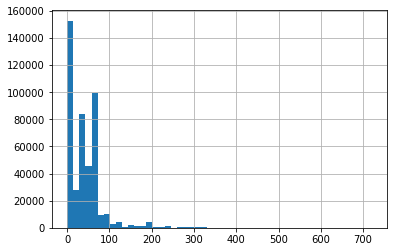

In [24]:
# Check the distribution of our numerical values
data['programme_duration_mins'].hist(bins=50)

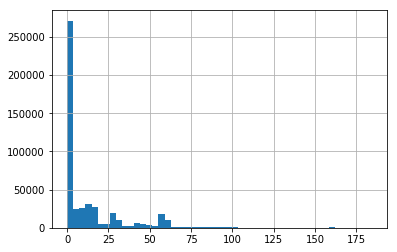

In [25]:
data[data['min_watched']<200]['min_watched'].hist(bins=50)

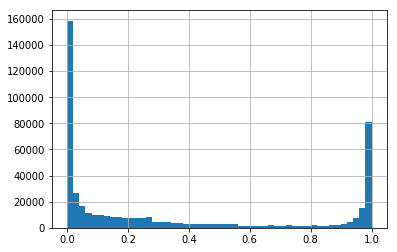

In [26]:
data['percentage_watched'].hist(bins=50)

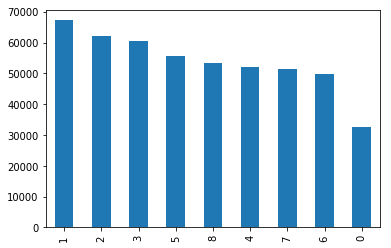

In [27]:
# Check whether we have more or less the same amount of data for each two week period
data['twoweek'].value_counts().plot(kind='bar')

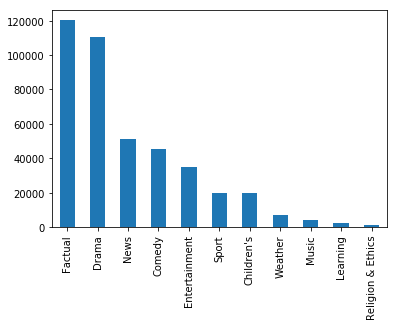

In [28]:
# Check distribution of categorical values
data['genre'].value_counts().plot(kind='bar')

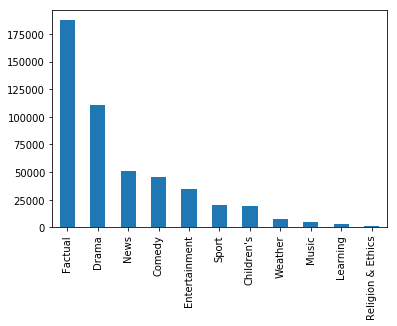

In [29]:
data['enriched_genre'].value_counts().plot(kind='bar')

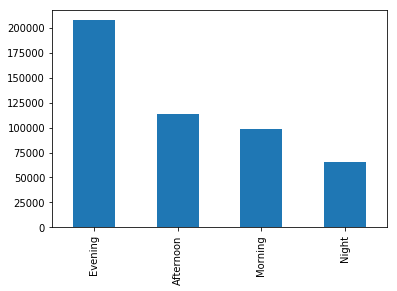

In [30]:
data['time_of_day'].value_counts().plot(kind='bar')

### Preparing the data for the prediction task

In [31]:
# based on the data above, we will drop week 0
data=data[data['twoweek']>0]

# Ensuring that we only train on the data we should have
data_training=data[data['twoweek']<7]
data_val=data[data['twoweek']<8]
data_test=data[data['twoweek']==8]

In [32]:
# Create a function that pivots the data based on customer and gives us all the data we need
def pivot_data(dataframe):
    data=pd.pivot_table(dataframe,values='min_watched', index=['user_id'],columns=['twoweek'], aggfunc=sum)
    data.fillna(0,inplace=True)
    # How much of average did each viewer watch?
    data['average_completion']=dataframe.groupby('user_id')['percentage_watched'].mean()
    # How many sessions did the person have with us
    data['total_sessions']=dataframe.groupby('user_id')['streaming_id'].nunique()
    # How much did the viewer watch in total this year sop far
    data['total_watched']=dataframe.groupby('user_id')['min_watched'].sum()
    # How many times has the viewer watched something
    data['number_watched']=dataframe.groupby('user_id')['streaming_id'].count()
    # Genre most watched by the viewer
    data['most_genre']=pd.pivot_table(dataframe,values='min_watched', index=['user_id'],\
                                         columns=['enriched_genre'], aggfunc=sum).idxmax(axis=1)
    # Number of genres watched
    data['num_genre']=pd.pivot_table(dataframe,values='min_watched', index=['user_id'],\
                                         columns=['enriched_genre'], aggfunc=sum).count(axis=1)
    # Favourite day of the week to watch
    data['most_weekday']=pd.pivot_table(dataframe,values='min_watched', index=['user_id'],\
                                         columns=['weekday'], aggfunc=sum).idxmax(axis=1)
    # Number of weekdays watched
    data['num_weekday']=pd.pivot_table(dataframe,values='min_watched', index=['user_id'],\
                                         columns=['weekday'], aggfunc=sum).count(axis=1)
    # Favorite time of day to watch
    data['most_timeday']=pd.pivot_table(dataframe,values='min_watched', index=['user_id'],\
                                         columns=['time_of_day'], aggfunc=sum).idxmax(axis=1)
    # Number of times of day
    data['num_timeday']=pd.pivot_table(dataframe,values='min_watched', index=['user_id'],\
                                         columns=['time_of_day'], aggfunc=sum).count(axis=1)
    return data

In [33]:
data_viewer=pivot_data(data_training)
data_viewer.reset_index().head()

twoweek,user_id,1,2,3,4,5,6,average_completion,total_sessions,total_watched,number_watched,most_genre,num_genre,most_weekday,num_weekday,most_timeday,num_timeday
0,0001c6,16.679200,0.000000,0.0000,0.000000,0.000000,0.152550,0.371496,2,16.831750,3,News,1,weekday_1,2,Evening,2
1,000c1a,0.162867,0.147467,107.0984,145.686233,2.286283,100.487767,0.228043,22,355.869017,28,Factual,4,weekday_3,5,Morning,3
2,001c53,1.866300,0.000000,0.0000,0.000000,1.309867,0.000000,0.489419,3,3.176167,3,News,2,weekday_2,2,Morning,2
3,001d44,0.000000,0.000000,0.0000,14.547700,0.000000,0.000000,0.085238,1,14.547700,2,Sport,2,weekday_6,1,Morning,1
4,002b2e,291.477033,0.000000,0.0000,0.000000,0.000000,0.000000,0.228233,17,291.477033,21,Factual,5,weekday_2,5,Evening,3


In [34]:
# Turn our categorical variables into bins so that we can run models on this
data_viewer=pd.get_dummies(data_viewer).reset_index()
data_viewer.head()

,user_id,1,2,3,4,5,6,average_completion,total_sessions,total_watched,number_watched,num_genre,num_weekday,num_timeday,most_genre_Children's,most_genre_Comedy,most_genre_Drama,most_genre_Entertainment,most_genre_Factual,most_genre_Learning,most_genre_Music,most_genre_News,most_genre_Religion & Ethics,most_genre_Sport,most_genre_Weather,most_weekday_weekday_0,most_weekday_weekday_1,most_weekday_weekday_2,most_weekday_weekday_3,most_weekday_weekday_4,most_weekday_weekday_5,most_weekday_weekday_6,most_timeday_Afternoon,most_timeday_Evening,most_timeday_Morning,most_timeday_Night
0,0001c6,16.679200,0.000000,0.0000,0.000000,0.000000,0.152550,0.371496,2,16.831750,3,1,2,2,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
1,000c1a,0.162867,0.147467,107.0984,145.686233,2.286283,100.487767,0.228043,22,355.869017,28,4,5,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2,001c53,1.866300,0.000000,0.0000,0.000000,1.309867,0.000000,0.489419,3,3.176167,3,2,2,2,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,001d44,0.000000,0.000000,0.0000,14.547700,0.000000,0.000000,0.085238,1,14.547700,2,2,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
4,002b2e,291.477033,0.000000,0.0000,0.000000,0.000000,0.000000,0.228233,17,291.477033,21,5,5,3,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


In [35]:
# Setting up our target variables for our model (both the regression and the classification)
# Need to make sure we have the same user_id's as in our feature set (and in the same order)
target_min=pd.pivot_table(data_val,values='min_watched', index=['user_id'],columns=['twoweek'], aggfunc=sum)[7].reset_index()
target_min=target_min.fillna(0)

# Find the unique users in both the features and the target
users_target=target_min['user_id'].unique()
users_features=data_viewer['user_id'].unique()


# Find those users that are in the target but not in the feature
target_not_feature=[]
for user in users_target:
    if user not in users_features:
        target_not_feature.append(user)

# Find those users that are in the feature but not in the target
feature_not_target=[]
for user in users_features:
    if user not in users_target:
        feature_not_target.append(user)

# Print the size of the two sets
print('In target but not feature:',len(target_not_feature),'- In feature but not target:' ,len(feature_not_target))

In target but not feature: 39 - In feature but not target: 0


Since we have only issues with the target set, we will be able to just cleanse that set and don't need to worry about the feature set

In [36]:
# We will set the index to the user_id as this will make it easier to drop rows
# Then we drop the rows and then turn the remaining column into an array
target_min_clean=target_min.set_index(['user_id'])
target_min_clean.drop(target_not_feature,inplace=True)
target_min_clean.reset_index(inplace=True)
target_min_clean=target_min_clean[7].values

# Now we create the variables for the classification
target_class=[]
for user in target_min_clean:
    if user>0:
        target_class.append(1)
    else:
        target_class.append(0)
        
# Check to make sure the outcome makes sense
print(target_min_clean[:10])
print(target_class[:10])

[   0.          132.43208333    0.            0.24801667    0.            0.
    0.            0.            0.            0.        ]
[0, 1, 0, 1, 0, 0, 0, 0, 0, 0]


### Building the models

In [37]:
# Let's build a simple tree based classification model
from sklearn import tree

# We will use cross validation, so import helper functions for this
from sklearn.model_selection import cross_val_score, cross_val_predict

In [38]:
# Let's prepare the data we need
# We will fill remaining missing values with 0s as we don't know any better
features=data_viewer.drop(['user_id'],axis=1)
features.fillna(0,inplace=True)

In [39]:
# Let's check the size of our datasets
print('Number of samples in feature set:',len(features))
print('Number of samples in target set (classification):',len(target_class))
print('Number of samples in target set (regression):',len(target_min_clean))

Number of samples in feature set: 9068
Number of samples in target set (classification): 9068
Number of samples in target set (regression): 9068


In [40]:
# setup the model and develop a simple grid search against some key parameters
param_max_depth=[3,4,6,8,10]
param_min_leaf=[10,50,100,200]

# Let's keep track of our best parameters
best_score=0
best_param=[0,0]


for i in param_max_depth:
    for j in param_min_leaf:
        treeclass=tree.DecisionTreeClassifier(max_depth=i,min_samples_leaf=j)
        scores=cross_val_score(treeclass,features,target_class,scoring='accuracy')
        if np.mean(scores)>best_score:
            best_score=np.mean(scores)
            best_param=[i,j]
        print('Max Depth:',i, '- Min Sample Leaf:',j)
        print('Score:',np.mean(scores),'-',scores)

# print the overall best results
print('\nBest Model overall:')
print('Best Settings: Max Depth:',best_param[0], '- Min Sample Leaf:',best_param[1])
print('Score:', best_score)

Max Depth: 3 - Min Sample Leaf: 10
Score: 0.80414750243 - [ 0.81012239  0.78862058  0.81369954]
Max Depth: 3 - Min Sample Leaf: 50
Score: 0.805691222796 - [ 0.81475356  0.78862058  0.81369954]
Max Depth: 3 - Min Sample Leaf: 100
Score: 0.80547076429 - [ 0.81343037  0.78862058  0.81436135]
Max Depth: 3 - Min Sample Leaf: 200
Score: 0.799846700701 - [ 0.81012239  0.77968905  0.80972866]
Max Depth: 4 - Min Sample Leaf: 10
Score: 0.809550341273 - [ 0.81773073  0.79887529  0.812045  ]
Max Depth: 4 - Min Sample Leaf: 50
Score: 0.809440330946 - [ 0.81806153  0.79589811  0.81436135]
Max Depth: 4 - Min Sample Leaf: 100
Score: 0.810101888901 - [ 0.81673834  0.79953688  0.81403044]
Max Depth: 4 - Min Sample Leaf: 200
Score: 0.803485470135 - [ 0.81012239  0.79060536  0.80972866]
Max Depth: 6 - Min Sample Leaf: 10
Score: 0.799736033596 - [ 0.80086007  0.79225935  0.80608868]
Max Depth: 6 - Min Sample Leaf: 50
Score: 0.802382301904 - [ 0.80879921  0.79325174  0.80509596]
Max Depth: 6 - Min Sample Le

In [41]:
# Let's build a simple regression
from sklearn import linear_model

We can reuse the features from above

/Users/rosiecam/dev/dl-experiments/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


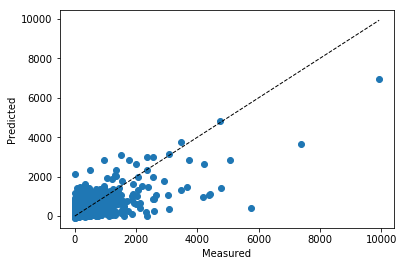

In [42]:
# We setup a simple linear regression, again using cross validation
reg = linear_model.LinearRegression()

predicted = cross_val_predict(reg, features,target_min_clean, cv=4)

# Let us plot the predicted and actual values
fig, ax = plt.subplots()
ax.scatter(target_min_clean, predicted)
ax.plot([target_min_clean.min(), target_min_clean.max()], [target_min_clean.min(), target_min_clean.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [43]:
# Or we could also look at the score of the regression models
cross_val_score(reg, features,target_min_clean, cv=4)

array([ 0.5503173 ,  0.69652176,  0.47596058,  0.56650797])

It looks quite varied, so we probably need to put in a bit more effort into our model. <br>
Another thing we could do at this point is to only build a regression model for the not zero values and then combine the results with our classification model. <br>